# Conversion Modelling Project - Andrew Charabin
February 14th, 2024

## Analysis

In [ ]:
## Import Packages

import numpy as np, pandas as pd, seaborn as sb, matplotlib.pyplot as plt, random, seaborn as sb, plotly.express as px, plotly.graph_objects as go, plotly.io as pio
pio.renderers.default='plotly_mimetype'
from sklearn import linear_model, metrics
from xgboost import XGBClassifier, XGBRegressor

In [ ]:
## Load & Head Datasets

funnel_path = pd.read_csv("funnel_path.csv")
users = pd.read_csv("users.csv")

print(funnel_path.head(1))
print(users.head(1))

   user_id          funnel_steps
0     1001  collect_contact_info
   user_id  age   device  income  num_conditions      premium  \
0     1001   56  desktop  157490               5  2490.123774   

  marketing_channels  
0          instagram  


In [ ]:
## Add Additional Information Provided in Case

# Build Step Number Table
# print(funnel_path['funnel_steps'].unique())
step_numbers = pd.DataFrame({'funnel_steps' : funnel_path['funnel_steps'].unique(), 'step_number' : [2,1,4,5,6,3]}).sort_values(by = 'step_number')
print(step_numbers, end = '\n\n')
last_step_number = max(step_numbers['step_number'])

# Join Step Number Table
funnel_path = funnel_path.merge(step_numbers)
print(funnel_path.head(1), end = '\n\n')

# Build Marketing Channels Costs Table
# print(users['marketing_channels'].unique())
marketing_channels = pd.DataFrame({'marketing_channels' : users['marketing_channels'].unique(), 'CPA' : [85, 95, 400, 500, 150]}).sort_values(by = 'CPA')
print(marketing_channels, end = '\n\n')

# Join Marketing Channels Costs Table
users = users.merge(marketing_channels)
print(users.head(1), end = '\n\n')

# Round Premium to 2 Decimal Places and Set Potential Revenue Column
users['premium'] = round(users['premium'],2)
users['potential_revenue'] = users['premium'] * 1.36
users.head(1)

           funnel_steps  step_number
1     started_navigator            1
0  collect_contact_info            2
5         viewed_quotes            3
2    application_submit            4
3         phone_connect            5
4         sign_and_exam            6

   user_id          funnel_steps  step_number
0     1001  collect_contact_info            2

  marketing_channels  CPA
0          instagram   85
1     paid_search_nb   95
4           facebook  150
2                 tv  400
3            podcast  500

   user_id  age   device  income  num_conditions      premium  \
0     1001   56  desktop  157490               5  2490.123774   

  marketing_channels  CPA  
0          instagram   85  



,user_id,age,device,income,num_conditions,premium,marketing_channels,CPA,potential_revenue
0,1001,56,desktop,157490,5,2490.12,instagram,85,3386.5632


In [ ]:
## Dataset Verification

# Ensure no Duplicates
assert max(users['user_id'].duplicated()) == False
assert max(pd.concat([funnel_path['user_id'], funnel_path['funnel_steps']], axis = 1).duplicated()) == False

# Merge Users with Funnel Paths
users_x_funnel_path = users.merge(funnel_path, on = 'user_id', how = 'outer')
assert max(users_x_funnel_path['funnel_steps'].isna()) == False
users_x_funnel_path.head(1)

,user_id,age,device,income,num_conditions,premium,marketing_channels,CPA,potential_revenue,funnel_steps,step_number
0,1001,56,desktop,157490,5,2490.12,instagram,85,3386.5632,collect_contact_info,2


In [ ]:
# Get Last Funnel Step for Each User
users_last_funnel_step = users_x_funnel_path.groupby('user_id').max('step_number')['step_number'].rename('max_step_number').reset_index()
users_x_funnel_path.head()

# Ensure Full Chronology of Funnel Steps Are Traversed
all_steps = users[['user_id']].merge(step_numbers, how='cross').merge(users_x_funnel_path, how='left').merge(users_last_funnel_step)
assert max(all_steps[all_steps['step_number'] <= all_steps['max_step_number']].isna().all(axis=1)) == False

# Merge Last Funnel Step for Each User
users_x_funnel_path = users_x_funnel_path.merge(users_last_funnel_step)

In [ ]:
# Obtain Summary Statistics

users_x_funnel_path.info()
users_x_funnel_path.describe()

# 'Discrepancy' that while not all users have reached the viewed_quotes step, all users have a premium field that is greater than 0.
# Assumption that case data was simulated, so for simplicity will leave data as is (vs. removal of the respective observations).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27629 entries, 0 to 27628
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             27629 non-null  int64  
 1   age                 27629 non-null  int64  
 2   device              27629 non-null  object 
 3   income              27629 non-null  int64  
 4   num_conditions      27629 non-null  int64  
 5   premium             27629 non-null  float64
 6   marketing_channels  27629 non-null  object 
 7   CPA                 27629 non-null  int64  
 8   potential_revenue   27629 non-null  float64
 9   funnel_steps        27629 non-null  object 
 10  step_number         27629 non-null  int64  
 11  max_step_number     27629 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 2.5+ MB


,user_id,age,income,num_conditions,premium,CPA,potential_revenue,step_number,max_step_number
count,27629.000000,27629.000000,27629.000000,27629.000000,27629.000000,27629.000000,27629.000000,27629.000000,27629.000000
mean,5945.570922,35.539144,149237.347823,2.746571,1701.750414,272.020703,2314.380563,2.313656,3.627312
std,2922.834925,8.948595,49696.945596,1.171044,375.893836,193.370028,511.215617,1.348173,1.553466
min,1001.000000,18.000000,36996.000000,0.000000,315.660000,85.000000,429.297600,1.000000,1.000000
25%,3396.000000,29.000000,114784.000000,2.000000,1442.940000,95.000000,1962.398400,1.000000,3.000000
50%,5819.000000,35.000000,139479.000000,3.000000,1698.910000,150.000000,2310.517600,2.000000,3.000000
75%,8536.000000,42.000000,172243.000000,4.000000,1954.840000,500.000000,2658.582400,3.000000,5.000000
max,11000.000000,65.000000,297935.000000,7.000000,3267.370000,500.000000,4443.623200,6.000000,6.000000


## Question 1

In [ ]:
# Build Aggregated Dataset to Visualize in Tableau

users_x_funnel_path['converted_next_step'] = np.where((users_x_funnel_path['step_number'] < users_x_funnel_path['max_step_number']) | (users_x_funnel_path['step_number'] == last_step_number), 1, 0)
users_x_funnel_path['converted_end_of_funnel'] = np.where(users_x_funnel_path['max_step_number'] == last_step_number, 1, 0)
users_x_funnel_path['revenue'] = np.where(users_x_funnel_path['converted_end_of_funnel'] == 1, users_x_funnel_path['potential_revenue'], 0)

conversion_rates = users_x_funnel_path.groupby(['step_number','funnel_steps']).agg({'potential_revenue':'sum','revenue':'sum','CPA':['mean','sum'],'converted_next_step':'mean','converted_end_of_funnel':'mean','user_id':'count'})
conversion_rates['efficiency'] = conversion_rates[('revenue','sum')] / conversion_rates[('CPA','sum')]
conversion_rates['potential_efficiency'] = conversion_rates[('potential_revenue','sum')] / conversion_rates[('CPA','sum')]
del conversion_rates[('revenue','sum')], conversion_rates[('CPA','sum')]
conversion_rates.columns = conversion_rates.columns.droplevel(1)
conversion_rates = conversion_rates.reset_index(1)
conversion_rates

,funnel_steps,potential_revenue,CPA,converted_next_step,converted_end_of_funnel,user_id,efficiency,potential_efficiency
step_number,,,,,,,,
1,started_navigator,2.327293e+07,274.704000,0.722000,0.078400,10000,0.627128,8.472003
2,collect_contact_info,1.675934e+07,274.030471,0.726454,0.108587,7220,0.870733,8.470730
3,viewed_quotes,1.213652e+07,275.053384,0.544328,0.149476,5245,1.194149,8.412628
4,application_submit,6.456083e+06,278.101576,0.534151,0.274606,2855,2.169759,8.131291
5,phone_connect,3.596402e+06,241.140984,0.514098,0.514098,1525,4.684682,9.779742
6,sign_and_exam,1.722745e+06,236.919643,1.000000,1.000000,784,9.274786,9.274786


#### a. What is our revenue generation through the funnel?
Assumptions:
1. Revenue is 'generated' upon the 'sign_and_exam' step, otherwise its considered 'potential revenue'
2. The policy with the lowest premiums presented is purchased by the user.
3. For the purposes of analyzing potential revenue by funnel step, the same users potential revenue will show up in all subsequent steps.

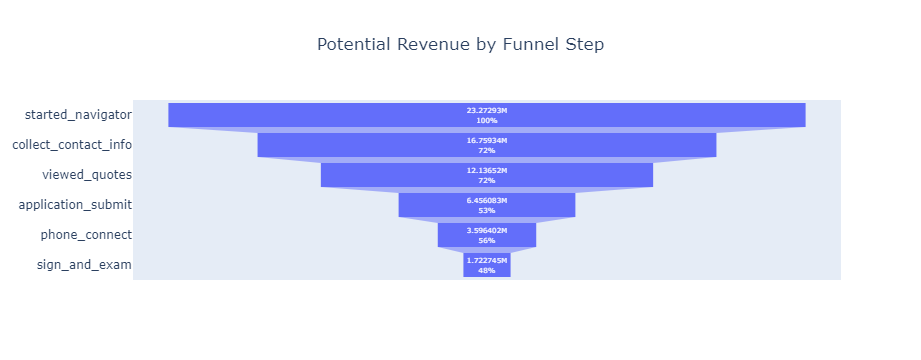

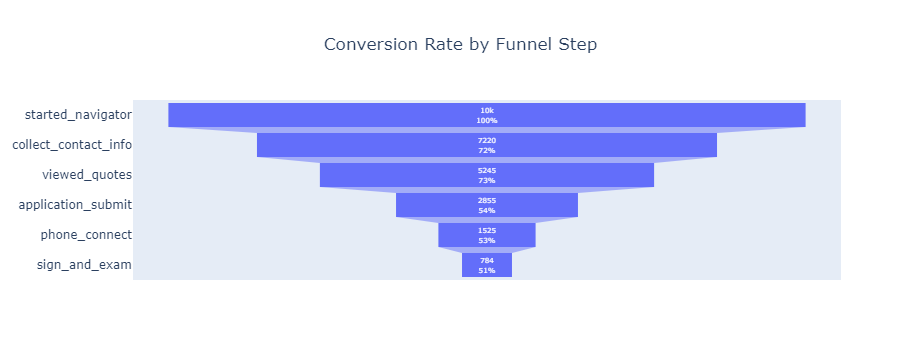

In [ ]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    y = conversion_rates['funnel_steps'],
    x =  conversion_rates['potential_revenue'],
    textinfo = "value+percent previous"))
fig.update_layout(title_text = 'Potential Revenue by Funnel Step', title_x = 0.5)
fig.show()

## c. What is the conversion rate through the funnel?

comb = pd.concat([conversion_rates[['funnel_steps','converted_next_step']].rename(columns = {'converted_next_step':'converted'}), conversion_rates[['funnel_steps','converted_end_of_funnel']].rename(columns = {'converted_end_of_funnel':'converted'})],axis=0)
comb = comb[comb['funnel_steps']!='sign_and_exam']

fig = go.Figure()

fig.add_trace(go.Funnel(
    y = conversion_rates['funnel_steps'],
    x =  conversion_rates['user_id'],
    textinfo = "value+percent previous"))
fig.update_layout(title_text = 'Conversion Rate by Funnel Step', title_x = 0.5)
fig.show()

#### Key Takeaways
- Loss in potential revenue through the funnel appears to ~ follow loss in users, indicating no major variation in the average potential revenue per user throughout the funnel.
- Increasing drop off of users is occuring in the last 3 steps from application submit to sign and exam. While the increasing drop off at application_submit seems reasonable, I'd like to further understand if there are controllable factors causing phone_connect to have a reduced conversion rate, i.e. such as not having the right phone number or best time to call an applicant to obtain further details.

#### b. How does CPA change through the funnel?
Assumptions:
- For the purposes of analyzing CPA by funnel step, the same users CPA will show up in all subsequent steps.

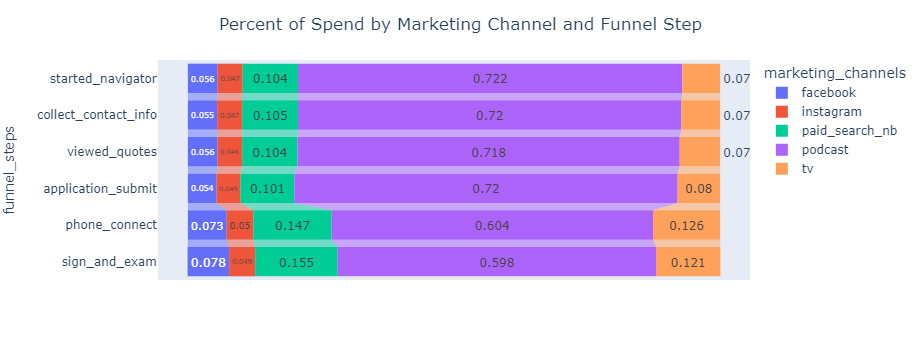

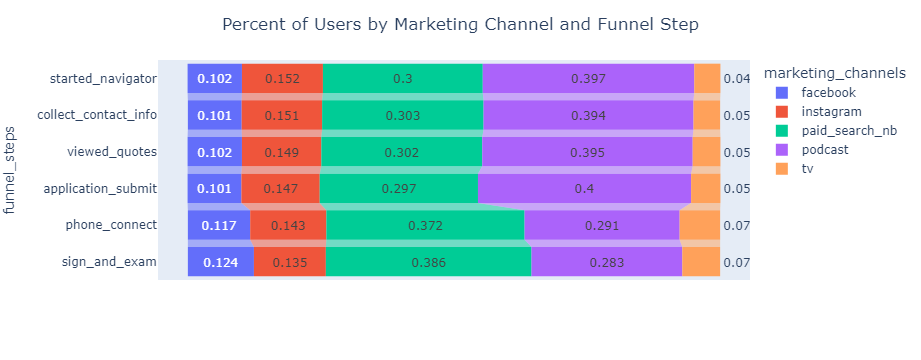

In [ ]:
funnel_cpa = users_x_funnel_path.groupby(['step_number','funnel_steps','marketing_channels']).agg({'CPA':['sum'], 'user_id':['count'], 'revenue':'sum', 'potential_revenue':'sum'})
funnel_cpa.columns = funnel_cpa.columns.droplevel(1)
funnel_cpa = funnel_cpa.reset_index([1,2])
funnel_cpa

funnel_cpa = funnel_cpa.merge(funnel_cpa.groupby('funnel_steps')['CPA'].sum().rename('spend_by_step').reset_index())
funnel_cpa['percent_of_spend_at_step'] = round(funnel_cpa['CPA']/funnel_cpa['spend_by_step'],3)

fig = px.funnel(funnel_cpa,x=funnel_cpa['percent_of_spend_at_step'], y=funnel_cpa['funnel_steps'], color = funnel_cpa['marketing_channels'])
fig.update_layout(title_text = 'Percent of Spend by Marketing Channel and Funnel Step', title_x = 0.5)
fig.show()

funnel_cpa = funnel_cpa.merge(funnel_cpa.groupby('funnel_steps')['user_id'].sum().rename('user_count_by_step').reset_index())
funnel_cpa['percent_of_users_at_step'] = round(funnel_cpa['user_id']/funnel_cpa['user_count_by_step'],3)

fig = px.funnel(funnel_cpa,x=funnel_cpa['percent_of_users_at_step'], y=funnel_cpa['funnel_steps'], color = funnel_cpa['marketing_channels'])
fig.update_layout(title_text = 'Percent of Users by Marketing Channel and Funnel Step', title_x = 0.5)
fig.show()

# Uncomment to Explicitly See CPA by Step
# fig = px.funnel(conversion_rates,x=conversion_rates['CPA'], y=conversion_rates['funnel_steps'])
# fig.update_layout(title_text = 'CPA by Users in Funnel Step', title_x = 0.5)
# fig.show()

#### Key Takeaways
- While podcasting makes up ~72% of the initial spend, it results in ~28% of the converted users. The major drop off point users from the podcast channel occurs at the phone connect step.

#### d. How does our efficiency rate change through the funnel?
Assumptions:
- For the purposes of analyzing efficiency rate by funnel step, the associated revenue and CPA for a given user will be considered in the efficiency rates for all steps they have traversed.

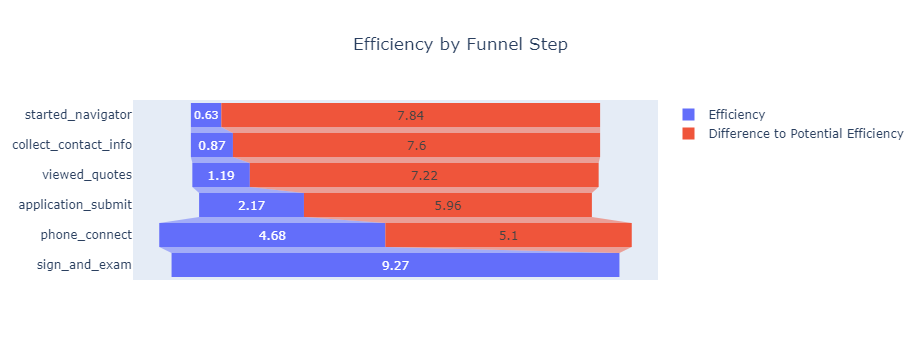

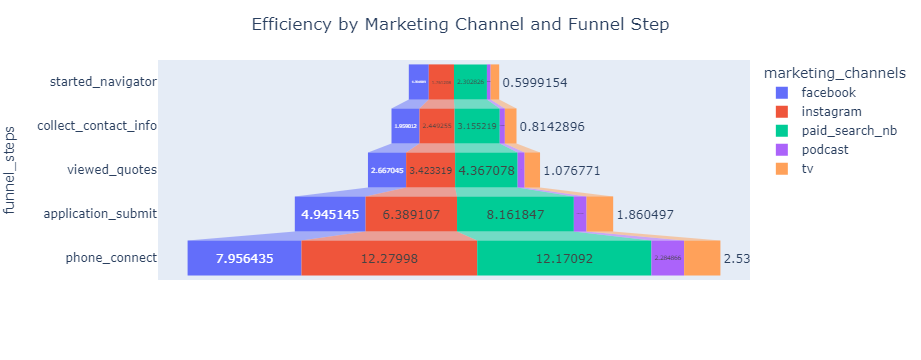

In [ ]:
conversion_rates['potential_efficiency'] = round(conversion_rates['potential_efficiency'],2)
conversion_rates['efficiency'] = round(conversion_rates['efficiency'],2)

fig = go.Figure()
fig.update_layout(title_text = 'Efficiency by Funnel Step', title_x = 0.5)

fig.add_trace(go.Funnel(
    name = 'Efficiency',
    y = conversion_rates['funnel_steps'],
    x = conversion_rates['efficiency'],
    textinfo = "value"))

fig.add_trace(go.Funnel(
    name = 'Difference to Potential Efficiency',
    y = conversion_rates['funnel_steps'],
    x = conversion_rates['potential_efficiency'] - conversion_rates['efficiency'],
    textinfo = "value"))
fig.show()

funnel_cpa['potential_efficiency'] = funnel_cpa['potential_revenue']/funnel_cpa['CPA']
funnel_cpa['efficiency'] = funnel_cpa['revenue']/funnel_cpa['CPA']
funnel_cpa_sub = funnel_cpa[funnel_cpa['funnel_steps']!='sign_and_exam']

fig = px.funnel(funnel_cpa_sub,x=funnel_cpa_sub['efficiency'], y=funnel_cpa_sub['funnel_steps'], color = funnel_cpa_sub['marketing_channels'])
fig.update_layout(title_text = 'Efficiency by Marketing Channel and Funnel Step', title_x = 0.5)
fig.show()

#### Key Takeaways
- Funnel efficiency dips well below 1 at the onset, indicating the funnel is not profitable.
- The root drivers of low efficiency come from the Podcasting and TV marketing channels.
- It may be worthwhile considering pausing, reducing the cost, or changing the nature of user acquisition efforts in these channels, to restore a net positive efficiency at the start of the funnel.

#### e. Please present these metrics visually. How do you expect these metrics to work together?
- The mix and behavior of users acquired by marketing channel can be observed in each chart each from a different lens.
- Efficiency combines the effects observed in the other charts - of potential revenue conversion, user conversion, and CPA - into one holistic view of funnel profitability.
- Poor funnel efficiency can be isolated to the expensive podcast (and TV) channel.
- Interestingly, while the podcast channel has a CPA that is 5X other channels like instagram and paid search, it has a lower conversion rate than these channels, which further compounds the drop ob in efficiency.

## Question 2

#### Approach

Part A - 2 Models will be developed
1. Predict converted_end_of_funnel
- A linearly separable model (logistic regression) will be compared against a boosted tree-based model (XGBoost Classifier)
- Should the linear model perform better on a validation set, multi-collinearity of predictors will need to be evaluated and address prior to making inferences
2. Predict potential revenue
- By using potential vs. generated revenue, it will ensure models 1 & 2 are ~ mutually exclusive, and will provide predictions than together can be used to appropriately segment users
- A linearly separable model (linear regression) will be compared against a boosted tree-based model (XGBoost Regressor)

Part B - Best model output will be combined and analyzed on the validations set

(array([22925.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  4704.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

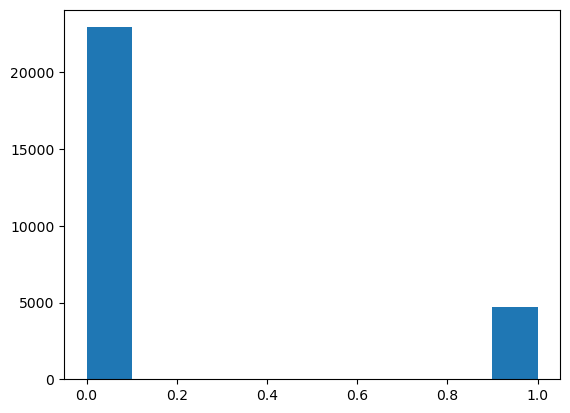

In [ ]:
# Visualize Distribution of Predicted Variables

# Converted
plt.hist(users_x_funnel_path['converted_end_of_funnel'])

(array([  110.,  1421.,  6055., 10280.,  7194.,  2249.,   303.,    14.]),
 array([ 500., 1000., 1500., 2000., 2500., 3000., 3500., 4000., 4500.]),
 <BarContainer object of 8 artists>)

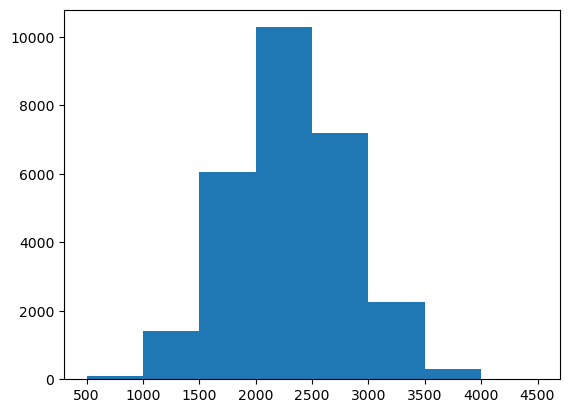

In [ ]:
# Potential Revenue

plt.hist(users_x_funnel_path['potential_revenue'],bins = list(range(500,5000,500)))

In [ ]:
## Prepare Dataset

# Select Relevant Predictor & Predicted Variables
# Notes
# 1. Potential revenue used instead of premium
# 2. Including revenue would invoke a circular reference bias
model_data = users_x_funnel_path.drop(['premium','marketing_channels','funnel_steps','max_step_number','converted_next_step','revenue'],axis = 1)
model_data = model_data.set_index('user_id')

# One Hot Encode Device
# Notes
# 1. Visually confirm sufficient volume by device type for inclusion in model
print(model_data['device'].value_counts())
# 2. First device type (desktop) is dropped and inferred effect (if any) will be captured by the intercept term
model_data = pd.concat([model_data.drop(['device'],axis=1),pd.get_dummies(model_data['device'],drop_first = True)],axis=1)

# Split into training and validation on a user_id level
# Notes
# 1. 80% of data will be used to fit the model
trainpercent = 0.8
# The remaining 20% of the data will be used to evaluate the best model to use to analyze predictive relationships
# Since the model won't be used to make predictions for future data points; a final unbiased judge of it's performance (testing set) won't be considered

# 2. User-level sampling is most appropriate, as user by funnel step level sampling would invoke 'leakage'
trainusers = random.sample(list(model_data.index.unique()),int(len(model_data.index.unique())*trainpercent))
train_x = model_data[model_data.index.isin(trainusers)]
val_x = model_data[~model_data.index.isin(trainusers)]

# Pop Y
train_y_converted = train_x.pop('converted_end_of_funnel')
val_y_converted = val_x.pop('converted_end_of_funnel')
train_y_potential_revenue = train_x.pop('potential_revenue')
val_y_potential_revenue = val_x.pop('potential_revenue')

train_x.head()

device
desktop           14039
mobile_android     7760
mobile_ios         5830
Name: count, dtype: int64


,age,income,num_conditions,CPA,step_number,mobile_android,mobile_ios
user_id,,,,,,,
1001,56,157490,5,85,2,False,False
1001,56,157490,5,85,1,False,False
1015,30,132164,2,85,2,False,False
1015,30,132164,2,85,1,False,False
1015,30,132164,2,85,4,False,False


<Axes: >

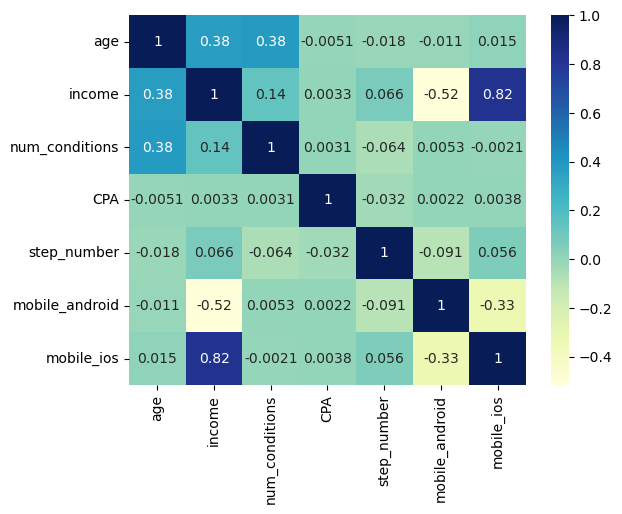

In [ ]:
# Evaluate Multicollinearity

sb.heatmap(train_x.corr(), cmap="YlGnBu", annot=True)

In [ ]:
# Drop income predictor as high collinearity with mobile_ios and mobile_android
del train_x['income']
del val_x['income']

In [ ]:
# Model 1 - Predict converted_end_of_funnel

In [ ]:
# Set Model Evaluation Function
# AUC score will used
def eval_model1(model, val_x, val_y):
    return round(metrics.roc_auc_score(val_y, model.predict_proba(val_x)[:,1])*100,2)

In [ ]:
# Logistic Regression Model
logistic_model = linear_model.LogisticRegression()
logistic_model.fit(train_x, train_y_converted)
eval_model1(logistic_model, val_x, val_y_converted)

C:\Users\Andrew Charabin\anaconda3\envs\pandas-playground\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



83.75

In [ ]:
# Fit XGBoost Model
xgboost_model=XGBClassifier(random_state=0)
xgboost_model.fit(train_x, train_y_converted)
eval_model1(xgboost_model, val_x, val_y_converted)

83.11

In [ ]:
# Get Coefficients From Best Model
model1_coef = pd.DataFrame([logistic_model.intercept_.transpose()] + list(logistic_model.coef_.transpose()), ['intercept'] + list(train_x.columns), columns=['Coefficients - Converted'])

In [ ]:
# Model 2 - Predict Potential Revenue

In [ ]:
# Set Model Evaluation Function
def eval_model2(model, val_x, val_y):
    return {'MAE': round(metrics.mean_absolute_error(val_y, model.predict(val_x))*100,2), 'MSE': round(metrics.mean_squared_error(val_y, model.predict(val_x))*100,2)}

In [ ]:
# Linear Regression Model
lm = linear_model.LinearRegression()
lm.fit(train_x, train_y_potential_revenue)
eval_model2(lm, val_x, val_y_potential_revenue)

{'MAE': 22234.43, 'MSE': 7747872.62}

In [ ]:
# Fit XGBoost Model
xgboost_regression_model=XGBRegressor(random_state=0)
xgboost_regression_model.fit(train_x, train_y_potential_revenue)
eval_model2(xgboost_regression_model, val_x, val_y_potential_revenue)

{'MAE': 22935.31, 'MSE': 8310908.44}

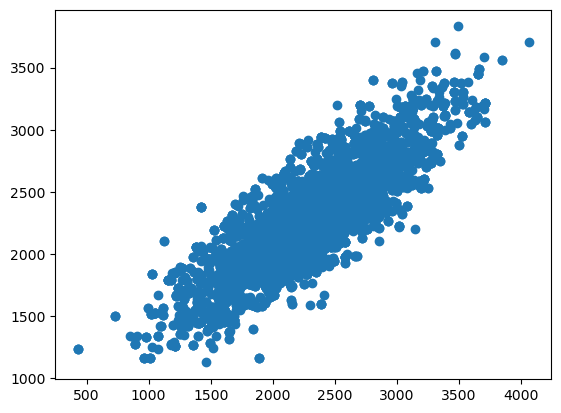

In [ ]:
# Plot Residuals From Best Model

plt.plot(val_y_potential_revenue, lm.predict(val_x), 'o')

# Upon visual inspecation, a linear trend looks appropriate and residuals are ~ independantly and identically distributed
# plt.plot(lm.predict(val_x) - val_y_potential_revenue, 'o')

In [ ]:
# Get Coefficients From Best Model
model2_coef = pd.DataFrame([lm.intercept_] + list(lm.coef_), ['intercept'] + list(val_x.columns), columns=['Coefficients - Potential Revenue'])

In [ ]:
# Part B - Combine Model Results

In [ ]:
comb_coef = model1_coef.join(model2_coef)
comb_coef

,Coefficients - Converted,Coefficients - Potential Revenue
intercept,-2.043837,869.835751
age,0.014554,18.700981
num_conditions,-0.672278,273.152223
CPA,-0.001433,0.012308
step_number,0.735716,-0.391225
mobile_android,-1.241216,-84.386625
mobile_ios,0.881275,241.635811


When looking at revenue generation at a segment level through the funnel, which features are associated with people converting through the funnel?
Which features are associated with people that do not convert through the funnel?

- mobile_ios is associated with improved conversion, while mobile_android is associated with reduced conversion, with the baseline being desktop
- Age is associated with improved conversion
- num_conditions is associated with worse conversion
- CPA is associated with worse conversion, presumed to be stemming from the drop in funnel step conversion observed in the podcast channel starting at application submit

- Given linearly separable model performed better than tree-based models (measured by predictive differentiation on a validation set), an initial assumption is derived that interaction effects between these features and the funnel step aren't considerable

Note on limitation of interpreting logitic regression coefficients:
- Because a logit link is used in logistic regression, the presented linear coefficients can't be interpreted akin to linear regression coefficients, and just the direction of the inferred relationship is considered here

Are there potentially segments that might have low conversion rates, but are still efficient generators of revenue? (HINT: There are relationships between these features. Approach this from a model based perspective vs visual inspection).

- Features with opposing coefficient direction (positive vs. negative) in the converted and potential revenue model indicate the possibility of still being efficient revenue generators,
- But required the increasing effect to dominate the decreasing effect.
- num_conditions and CPA are candidates to further evaluate.

To test the hypothesis for num_conditions, I will observe the inferred aggregate effect of decreasing and increasing the num_conditions by one point on the validation set below.

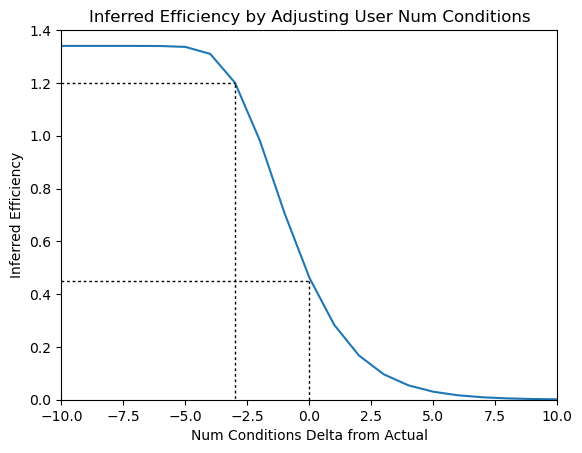

In [ ]:
# Observe on only the first step in the funnel
val_x_copy = val_x[val_x['step_number']==1].copy()

num_conditions_delta = [0]
pred_efficiency = [sum(lm.predict(val_x_copy)*logistic_model.predict_proba(val_x_copy)[:,1])/sum(val_x_copy['CPA'])]

for i in range(1,11):
    val_x_copy['num_conditions'] -= 1
    val_x_copy['num_conditions'] = np.where(val_x_copy['num_conditions'] < 0, 0, val_x_copy['num_conditions'])
    num_conditions_delta.append(-i)
    pred_efficiency.append(sum(lm.predict(val_x_copy)*logistic_model.predict_proba(val_x_copy)[:,1])/sum(val_x_copy['CPA']))

val_x_copy = val_x[val_x['step_number']==1].copy()

for i in range(1,11):
    val_x_copy['num_conditions'] += 1
    num_conditions_delta.append(i)
    pred_efficiency.append(sum(lm.predict(val_x_copy)*logistic_model.predict_proba(val_x_copy)[:,1])/sum(val_x_copy['CPA']))

df = pd.DataFrame({'num_conditions_delta':num_conditions_delta,'pred_efficiency':pred_efficiency}).sort_values('num_conditions_delta')
plt.plot(df['num_conditions_delta'],df['pred_efficiency'])
plt.xlabel("Num Conditions Delta from Actual")
plt.ylabel("Inferred Efficiency")
plt.title("Inferred Efficiency by Adjusting User Num Conditions")
ax = plt.gca()
ax.set_ylim([0, 1.4])
ax.set_xlim([-10, 10])
plt.plot([0, 0], [0, 0.44971701896447935], 'k-', lw=1,dashes=[2, 2])
plt.plot([-10, 0], [0.44971701896447935, 0.44971701896447935], 'k-', lw=1,dashes=[2, 2])

plt.plot([-3, -3], [-3, 1.2], 'k-', lw=1,dashes=[2, 2])
plt.plot([-10, -3], [1.2, 1.2], 'k-', lw=1,dashes=[2, 2])


#### Key Takeaways
- We can observe from the analysis that hypothetically 'reducing' the num conditions for each user by 3 would result in a dramatic increase in predicted efficiency of ~ 3X (from approximately 0.4 to 1.2)

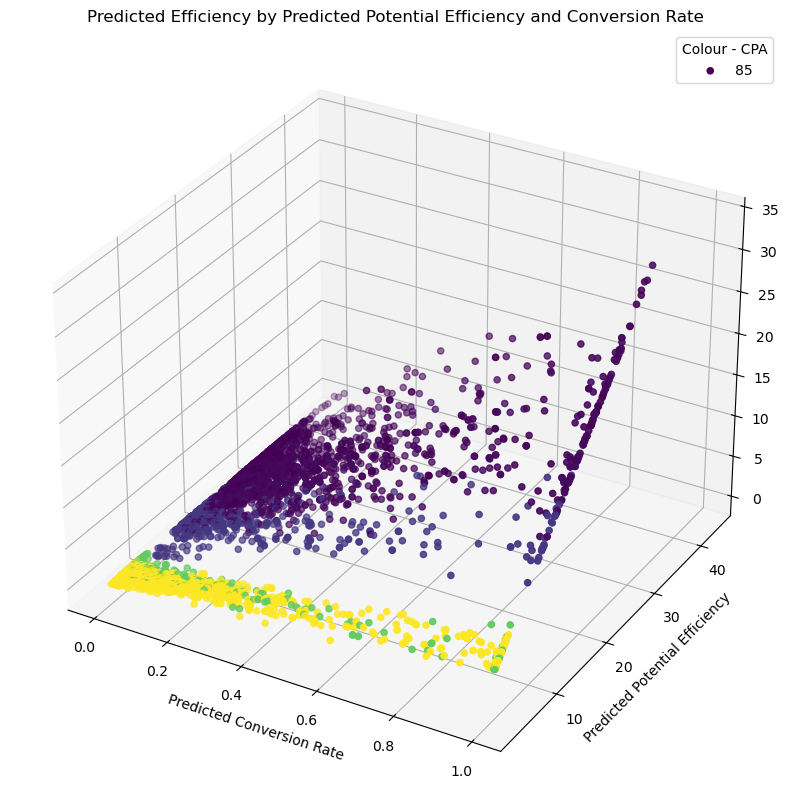

In [ ]:
# Let's combine the two models and CPA into one 3D chart on a user level

predicted_conversion = xgboost_model.predict_proba(val_x)[:,1]
predicted_potential_revenue = lm.predict(val_x)
cpa = val_x['CPA']
predicted_efficiency = predicted_potential_revenue * predicted_conversion / cpa

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(predicted_conversion, predicted_potential_revenue/cpa, predicted_efficiency,c=val_x['CPA'])
plt.xlabel("Predicted Conversion Rate")
plt.ylabel("Predicted Potential Efficiency")
plt.title("Predicted Efficiency by Predicted Potential Efficiency and Conversion Rate")
plt.gca().legend(val_x['CPA'].unique(),title = 'Colour - CPA')
plt.show()